## Configurações iniciais
Repetir todas as vezes no Colab. Na sua máquina, apenas uma.

In [8]:
!git clone https://github.com/UFMG-Finance-Club/analyzeBRfunds.git

fatal: destination path 'analyzeBRfunds' already exists and is not an empty directory.


In [62]:
!cd /content/analyzeBRfunds && git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/UFMG-Finance-Club/analyzeBRfunds
   02d05ab..7ce91fd  develop    -> origin/develop
Updating 02d05ab..7ce91fd
Fast-forward
 preprocess/DataClean.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [2]:
!cd /content/analyzeBRfunds && git checkout develop

Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'


In [3]:
!pip install dask[dataframe]

     |████████████████████████████████| 134 kB 7.1 MB/s 


In [4]:
import sys
sys.path.insert(0,'/content/analyzeBRfunds')

# Iniciando código

## DataDownload

O módulo DataDownload fornece utilitários para download de dados de fundos da Anbima, IBOVESPA e Risk-Free (obtido do NEFIN). 

### Download de fundos
Para o download de fundos, é necessário especificar os anos e meses iniciais e finais, além do diretório em que os arquivos serão gravados. Os dados são obtidos diretamente da [página da CVM](http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/), e nenhuma transformação é aplicada.

No código abaixo, baixamos dados referentes aos anos de 2017 a 2021:



In [5]:
from analyzeBRfunds.utils import DataDownload

In [ ]:
(
    DataDownload.download_funds(
        first_date=[2017, 1], last_date=[2022, 1], 
        outpath="/content/drive/MyDrive/data/raw"
    )
)

## DataClean

Com o módulo DataClean podemos aplicar alguns tratamentos na base de fundos, e reduzi-los através de determinados critérios.

No exemplo abaixo, vamos considerar dois deles:

1. **Merge**: podemos reduzir o universo de fundos das bases a um subconjunto especificado em um arquivo *fundos.csv* que contém uma coluna **CNPJ_FUNDO** com seus respectivos CNPJs (que devem estar apenas com caracteres numéricos).
2. **Filter**: podemos aplicar filtros intervalares nos dados. Cada filtro é uma entrada de um dicionário Python. No exemplo abaixo, dizemos que queremos fundos em que a variável *DT_COMPTC* (data) apareça entre ["2018-01-03", "2018-01-03"], ou seja, estamos mantendo apenas fundos que tenham estado em atividade no dia 03/01/2018. 

Todas essas transformações podem ser aplicadas de uma só vez usando a função **format_new_data**.


In [24]:
import importlib

In [3]:
from preprocess import DataClean

In [12]:
importlib.reload(DataClean)

<module 'preprocess.DataClean' from '/home/marcel/outros/ckrepo/analyzeBRfunds/preprocess/DataClean.py'>

In [50]:
(
    DataClean.Preprocess(inpath="/content/drive/MyDrive/data/raw")
    .format_new_data(
        outpath="/content/drive/MyDrive/data/preprocessed/2017_2021.csv",
        inrange_filters=[{"DT_COMPTC" : ["2018-01-03", "2018-01-03"]}],
        CNPJ_to_keep_path="/content/drive/MyDrive/data/auxiliary/fundos.csv", sep=";"
    )
)

Essas transformações também podem ser aplicadas separadamente e em momentos posteriores. No exemplo abaixo, leremos a base de novo e aplicaremos um segundo filtro: queremos apenas os fundos em que no dia 03/01/2020 (**DT_COMPTC**) o número de cotistas (**NR_COTST**) tenha sido maior do que 250. Como a base já foi tratada inicialmente, colocaremos o valor *existing* para o argumento *type*.

In [13]:
import numpy as np

prep_obj = (
    DataClean.Preprocess(inpath="/home/marcel/outros/ckrepo/analyzeBRfunds/data/preprocess/2017_2021.csv", type="existing")
    .apply_filters([{"DT_COMPTC" : ["2020-01-03", "2020-01-03"], "NR_COTST" : [250, np.inf]}])
)

O dado gerado pode ser acessado através do atributo *data*:

In [14]:
prep_obj.data

,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST,NOME_FUNDO
npartitions=1,,,,,,,,,
,object,object,float64,float64,float64,float64,float64,float64,object
,...,...,...,...,...,...,...,...,...


Note que é retornado um Dask DataFrame, que é *lazy*. Para visualizar os dados, i.e., computá-los, aplique o método *compute*:

In [15]:
prep_obj.data.compute()

,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST,NOME_FUNDO
0,17397804000179,2017-02-01,5.736429e+07,1.612580,5.741913e+07,21033.32,0.00,55.0,Apex Infinity 8 Long Biased Fc FIA
1,17397804000179,2017-02-02,1.648277e+08,1.615899,1.642899e+08,0.00,0.00,174.0,Apex Infinity 8 Long Biased Fc FIA
2,17397804000179,2017-02-03,1.676777e+08,1.631688,1.658952e+08,0.00,0.00,174.0,Apex Infinity 8 Long Biased Fc FIA
3,17397804000179,2017-02-06,1.655593e+08,1.621880,1.649049e+08,1087500.00,0.00,173.0,Apex Infinity 8 Long Biased Fc FIA
4,17397804000179,2017-02-07,1.658283e+08,1.620471,1.647766e+08,15000.00,0.00,173.0,Apex Infinity 8 Long Biased Fc FIA
...,...,...,...,...,...,...,...,...,...
270048,09087483000188,2020-09-24,3.902144e+07,2.339143,3.999969e+07,0.00,64216.55,273.0,Wa Dividend Yield FIA
270049,09087483000188,2020-09-25,3.889399e+07,2.330183,3.983260e+07,0.00,13882.57,272.0,Wa Dividend Yield FIA
270050,09087483000188,2020-09-28,3.815633e+07,2.275232,3.881881e+07,1074.00,75514.69,271.0,Wa Dividend Yield FIA
270051,09087483000188,2020-09-29,3.771789e+07,2.250453,3.838186e+07,0.00,14181.91,270.0,Wa Dividend Yield FIA


Naturalmente, também podemos escrevê-lo em algum arquivo:

In [16]:
prep_obj.write(outpath="/home/marcel/outros/ckrepo/analyzeBRfunds/data/preprocess/2017_2021.csv")

## Analisando performance

Com o utilitário FinancialMetrics podemos facilmente obter retornos e estimar alfas e betas.

In [1]:
from metrics import FinancialMetrics

fin_metrics = (
    FinancialMetrics.PerformanceMetrics(
        inpath="/home/marcel/outros/ckrepo/analyzeBRfunds/data/preprocess/2017_2021.csv",
        first_date=[2017,1,1], last_date=[2021,12,30]
    )
)

Podemos obter retornos através do atributo **returns_data**:

In [6]:
artwds = fin_metrics.returns_data.std().to_frame(name="std")

In [10]:
fin_metrics.returns_data.iloc[-1]

Name
00398561000190    0.011483
00601692000123    0.017526
01063897000165    0.016818
01608399000150    0.012932
01753087000130    0.013576
                    ...   
68670512000107    0.000623
73232530000139    0.017929
88198056000143    0.013777
96498654000166    0.008459
97261093000140    0.008259
Name: 2021-12-30, Length: 217, dtype: float64

Por padrão, o CNPJ é usado como identificador do fundo, mas isso pode ser alterado:

In [32]:
importlib.reload(FinancialMetrics)

<module 'metrics.FinancialMetrics' from '/home/marcel/outros/ckrepo/analyzeBRfunds/metrics/FinancialMetrics.py'>

In [33]:
fin_metrics = (
    FinancialMetrics.PerformanceMetrics(
        inpath="/home/marcel/outros/ckrepo/analyzeBRfunds/data/preprocess/2017_2021.csv",
        id_col="NOME_FUNDO", first_date=[2018,1,1], last_date=[2021,12,30]
    )
)

Utilizando os dados de retorno para obter os 5 fundos que melhor perfomaram durante o período de dados:

<AxesSubplot:xlabel='Date'>

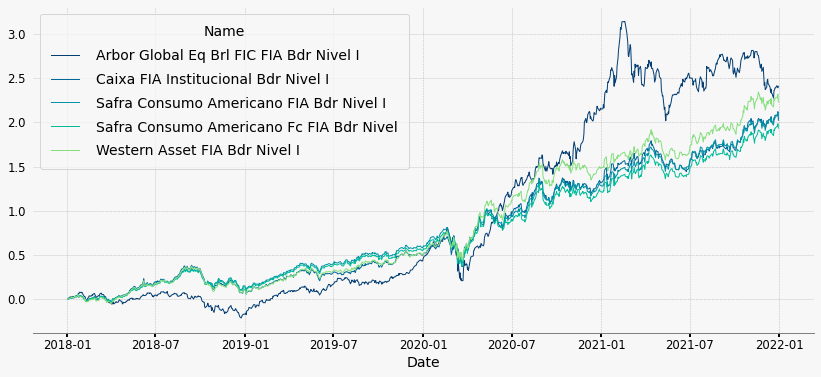

In [85]:
import matplotlib.pyplot as plt
plt.style.use("utils/finance_theme.mplstyle")

cumulative_returns = (fin_metrics.returns_data + 1).cumprod() - 1
funds_to_plot = (
    cumulative_returns
    .iloc[-1]
    .sort_values(ascending=False)
)

cumulative_returns.loc[:, cumulative_returns.columns.isin(funds_to_plot.iloc[:5].index)].plot()

Podemos incrementar os dados com os preços de fechamento (ajustados) do IBOV (obtido através do Yahoo Finance) e a taxa livre de risco diária (obtida do NEFIN: 30-day DI Swap). 

In [34]:
fin_metrics.increment_with("IBOV")
fin_metrics.increment_with("RISK_FREE", outpath_base="data/auxiliary/risk_free.csv")

E que tal olharmos algums métricas, como desvio-padrão e Sharpe?

In [36]:
fin_metrics.metrics_data

,std,annualized_std,cumulative_ret,annualized_ret,Sharpe
Name,,,,,
4um Marlin Dividendos FIA,0.014108,0.223965,0.419053,0.091916,0.415070
4um Small Caps FIA,0.014502,0.230216,0.694548,0.141692,0.620017
ARX Income Fc FIA,0.017103,0.271496,0.657495,0.135368,0.502450
ARX Long Term Fc FIA,0.017922,0.284511,0.266135,0.061079,0.218356
Af Invest Minas FIA,0.016262,0.258147,0.742961,0.149801,0.584343
...,...,...,...,...,...
Xp Investor 30 FIC FIA,0.018276,0.290124,0.454323,0.098672,0.343705
Xp Investor Dividendos 30 Fc FIA,0.016023,0.254352,0.267383,0.061342,0.245279
Xp Investor Dividendos FIA,0.016401,0.260364,0.279970,0.063980,0.249749


Por fim, no exemplo abaixo, vamos estimar os alfas e betas dos fundos, usando como base os dados do IBOV e da taxa livre de risco obtidos anteriormente, com parâmetros estimados via OLS (ordinary Least Squares), e num conjunto restrito de fundos (apenas o top 10% de melhor desempenho no período considerado)

In [100]:
from math import floor

funds_to_estimate = funds_to_plot.iloc[:floor(.1 * len(funds_to_plot))].index.values

In [101]:
fin_metrics.estimate_factors(selected=list(funds_to_estimate))

/home/marcel/outros/ckrepo/analyzeBRfunds/metrics/FinancialMetrics.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_factors["Market"] = data_factors["IBOV"] - data_factors["Risk_free"]


,Fund,Alpha,Beta,R_squared,Pvalue
0,Arbor Global Eq Brl FIC FIA Bdr Nivel I,0.000967,0.675349,0.494865,1.286761e-150
1,Western Asset FIA Bdr Nivel I,0.000896,0.364095,0.229778,9.348881e-59
2,Safra Consumo Americano FIA Bdr Nivel I,0.000843,0.404635,0.273407,1.812243e-71
3,Caixa FIA Institucional Bdr Nivel I,0.000836,0.337750,0.197010,1.148173e-49
4,Safra Consumo Americano Fc FIA Bdr Nivel,0.000801,0.404398,0.273371,1.858222e-71
5,Caixa FIA Bdr Nivel I,0.000799,0.336666,0.197359,9.231526e-50
6,Safra FIA Bdr Nivel I Pb,0.000756,0.417324,0.296037,2.310105e-78
7,BB Acoes Esg Globais Fc FIA -Bdr Nivel I,0.000763,0.326745,0.186289,9.017942e-47
8,Csn Invest Fdo de Investimento em Acoes,0.000932,1.023620,0.482162,3.262982e-145
9,Safra Fc FIA Bdr Nivel I,0.000713,0.417036,0.296090,2.224917e-78
